# Data @ ANZ Internship

>## Predictive Analytics


### Submitted by: Valency Colaco, Masters of Information Technology, University of Sydney

Installing library to access files from Google Drive

In [1]:
!pip install PyDrive

My Dataset is uploaded to Google Drive, and I want to read it from the drive directly. That's why these steps are required.

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"1yCQs5R05MlbZXni4hylcNKVq_wuawnij"})
downloaded.GetContentFile('ANZ synthesised transaction dataset.xlsx') 

The File is successfully read and can now be used in the program

In [5]:
import pandas as pd
df = pd.read_excel('ANZ synthesised transaction dataset.xlsx')

Just checking the file contents

In [6]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [7]:
salary_txns = df[df['txn_description'] == 'PAY/SALARY']

Filtered based on Salary Transactions only

In [8]:
salary_txns.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
50,posted,NaN,0,ACC-588564840,AUD,151.27 -33.76,PAY/SALARY,NaN,0.0,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01T11:00:00.000+0000,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,NaN,credit
61,posted,NaN,0,ACC-1650504218,AUD,145.01 -37.93,PAY/SALARY,NaN,0.0,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01T12:00:00.000+0000,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,NaN,credit
64,posted,NaN,0,ACC-3326339947,AUD,151.18 -33.80,PAY/SALARY,NaN,0.0,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01T12:00:00.000+0000,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,NaN,credit
68,posted,NaN,0,ACC-3541460373,AUD,145.00 -37.83,PAY/SALARY,NaN,0.0,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01T13:00:00.000+0000,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,NaN,credit
70,posted,NaN,0,ACC-2776252858,AUD,144.95 -37.76,PAY/SALARY,NaN,0.0,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01T13:00:00.000+0000,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,NaN,credit


Cleaning the data by dropping unnecessary fields

In [9]:
salary_txns = salary_txns.drop(['status', 
                                'card_present_flag', 
                                'bpay_biller_code', 
                                'currency', 
                                'merchant_id', 
                                'merchant_code', 
                                'merchant_suburb',
                                'merchant_state', 
                                'country', 
                                'merchant_long_lat', 
                                'movement',
                                'txn_description',
                                'extraction',
                                'transaction_id'], axis=1)
salary_txns = salary_txns.reset_index(drop=True)

Putting the location data in a usable format

In [10]:
long_lat = salary_txns['long_lat'].str.split("-", n = 1, expand = True)
salary_txns['long'] = long_lat[0]
salary_txns['lat'] = long_lat[1]
salary_txns = salary_txns.drop(['long_lat'], axis = 1)

In [11]:
salary_txns.head()

,account,first_name,balance,date,gender,age,amount,customer_id,long,lat
0,ACC-588564840,Isaiah,8342.11,2018-08-01,M,23,3903.95,CUS-1462656821,151.27,33.76
1,ACC-1650504218,Marissa,2040.58,2018-08-01,F,23,1626.48,CUS-2500783281,145.01,37.93
2,ACC-3326339947,Eric,3158.51,2018-08-01,M,22,983.36,CUS-326006476,151.18,33.80
3,ACC-3541460373,Jeffrey,2517.66,2018-08-01,M,24,1408.08,CUS-1433879684,145.00,37.83
4,ACC-2776252858,Kristin,2271.79,2018-08-01,F,43,1068.04,CUS-4123612273,144.95,37.76


In [12]:
salary_txns.nunique()

account        100
first_name      80
balance        883
date            65
gender           2
age             33
amount         100
customer_id    100
long            87
lat             85
dtype: int64

Now creating a sub-dataset with unique salary data and customers

Salary is paid every fortnight. Calculating average salary paid per fortnight multiplied by 26.071 fortnights a year gives us the annual salary.

In [13]:
customers = list(salary_txns['customer_id'].unique())

customer_data = []

for cust in customers:
    salary_txns_subset = salary_txns[salary_txns['customer_id'] == cust]
    salary_txns_subset = salary_txns_subset.reset_index(drop=True)
    account = salary_txns_subset['account'][0]
    first_name = salary_txns_subset['first_name'][0]
    gender = salary_txns_subset['gender'][0]
    age = salary_txns_subset['age'][0]
    long = salary_txns_subset['long'][0]
    lat = salary_txns_subset['lat'][0]
    avg_balance = round(sum(salary_txns_subset['balance']) / len(salary_txns_subset), 2)
    avg_salary = round(sum(salary_txns_subset['amount']) / len(salary_txns_subset), 2)
    row = (cust, account, first_name, gender, age, long, lat, avg_balance, avg_salary, round(avg_salary*26.071,2))
    customer_data.append(row)
    
customer_df = pd.DataFrame(customer_data, columns = ('customer_id',
                                                     'account',
                                                     'first_name',
                                                     'gender',
                                                     'age',
                                                     'long',
                                                     'lat',
                                                     'avg_balance',
                                                     'avg_salary',
                                                     'annual_salary')
                          )

# change gender to dummy variable
customer_df = pd.get_dummies(customer_df, columns = ['gender'], drop_first = True)

customer_df.head()

,customer_id,account,first_name,age,long,lat,avg_balance,avg_salary,annual_salary,gender_M
0,CUS-1462656821,ACC-588564840,Isaiah,23,151.27,33.76,15887.91,3903.95,101779.88,1
1,CUS-2500783281,ACC-1650504218,Marissa,23,145.01,37.93,10741.09,1626.48,42403.96,0
2,CUS-326006476,ACC-3326339947,Eric,22,151.18,33.80,8317.03,983.36,25637.18,1
3,CUS-1433879684,ACC-3541460373,Jeffrey,24,145.00,37.83,3877.38,1408.08,36710.05,1
4,CUS-4123612273,ACC-2776252858,Kristin,43,144.95,37.76,5210.70,1068.04,27844.87,0


Scatterplot 1 of Annual Salary vs Age

Text(0, 0.5, 'Annual Salary')

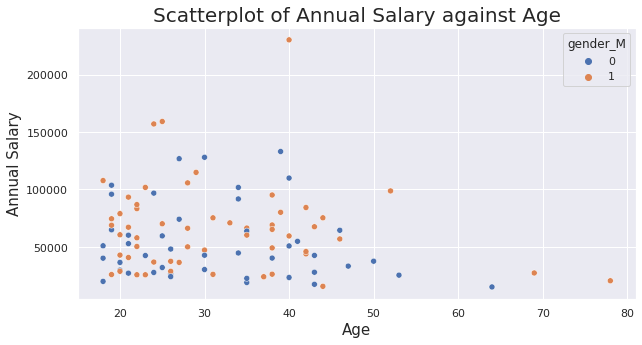

In [14]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
age_salary_graph = sns.scatterplot(x="age", y="annual_salary", hue = 'gender_M', data=customer_df)
age_salary_graph.axes.set_title("Scatterplot of Annual Salary against Age",fontsize=20)
age_salary_graph.set_xlabel("Age", fontsize=15)
age_salary_graph.set_ylabel("Annual Salary", fontsize=15)

Scatterplot 2 of Annual Salary vs Average Balance

Text(0, 0.5, 'Annual Salary')

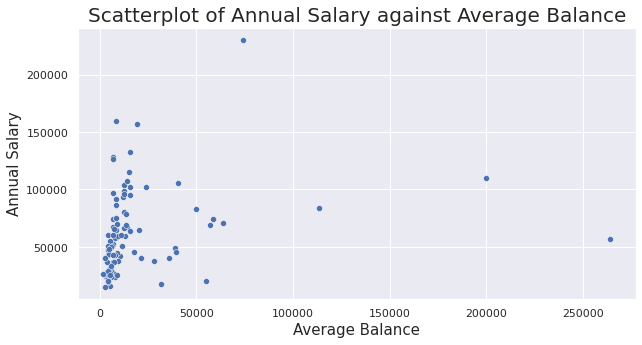

In [15]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
age_salary_graph = sns.scatterplot(x="avg_balance", y="annual_salary", data=customer_df)
age_salary_graph.axes.set_title("Scatterplot of Annual Salary against Average Balance",fontsize=20)
age_salary_graph.set_xlabel("Average Balance", fontsize=15)
age_salary_graph.set_ylabel("Annual Salary", fontsize=15)

Now comes the fun part. We split the refined dataset into 90% training and 10% testing. We also set up the Linear Regression Model here

In [16]:
# Split data
train, test = train_test_split(customer_df, test_size=0.1)
X = train[['age', 'avg_balance', 'long', 'lat', 'gender_M']]
y = train['annual_salary']
X_test = test[['age', 'avg_balance', 'long', 'lat', 'gender_M']]
y_test = test['annual_salary']

# Instantiate model
lm = LinearRegression()

# Fit model
lm.fit(X,y)

# Print the R-squared value for the model
print(lm.score(X, y))

0.1786352984831029


As we can see, the R^2 value is too low due to which the Root Mean Square Error (RMSE) is expected to be high

In [17]:
# Predict
y_predict = lm.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

244086.72850206518


An abnormal plot because the RMSE is too high

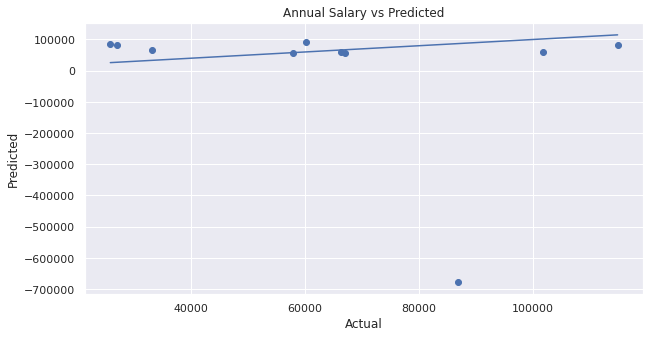

In [18]:
# Plot of predicted salary against actual salary
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Annual Salary vs Predicted")
plt.show()

Now setting up the decision tree model

In [19]:
# Instantiate model
model1 =  DecisionTreeRegressor(random_state=0, max_depth=5)

# Fit model
model1.fit(X,y)

# Print the R-squared value for the model
print (model1.score(X, y))

0.8033930736935384


In [20]:
# Predict
y_predict_2 = model1.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict_2)))

28902.27888455127


Pretty decent R^2 and low RSME. Plotting the tree now

In [21]:
import io 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus 

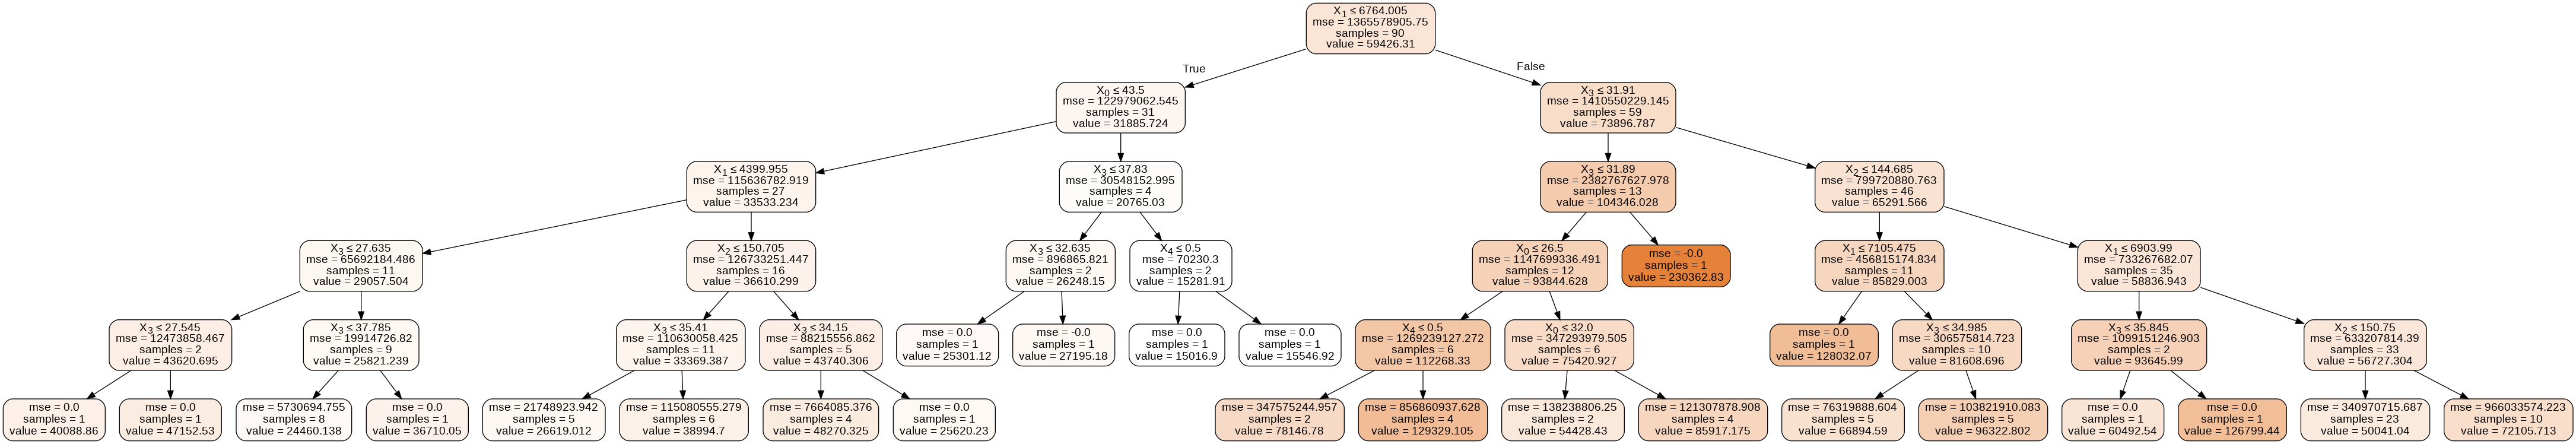

In [22]:
anz_dot = io.StringIO()

export_graphviz(model1, out_file=anz_dot,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(anz_dot.getvalue())  
Image(graph.create_png())

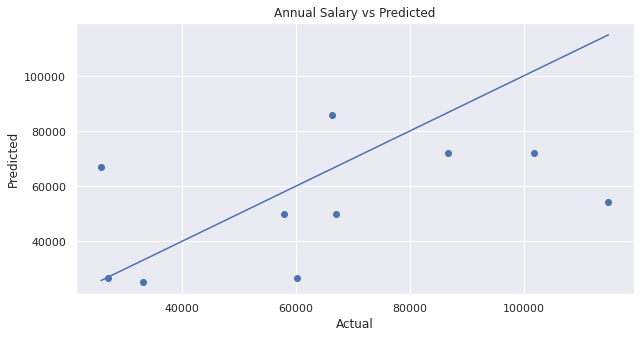

In [23]:

# Plot of predicted salary against actual salary
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Annual Salary vs Predicted")
plt.show()

Setting up the Random Forest Model as a bonus

In [24]:
# Instantiate model
model2 =  RandomForestRegressor(n_estimators = 1000, random_state = 0)

# Fit model
model2.fit(X,y)

# Print the R-squared value for the model
model2.score(X, y)

0.8895318644621022

In [25]:
# Predict
y_predict_3 = model2.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict_3)))

26475.59207387387


Wow. This was even more accurate

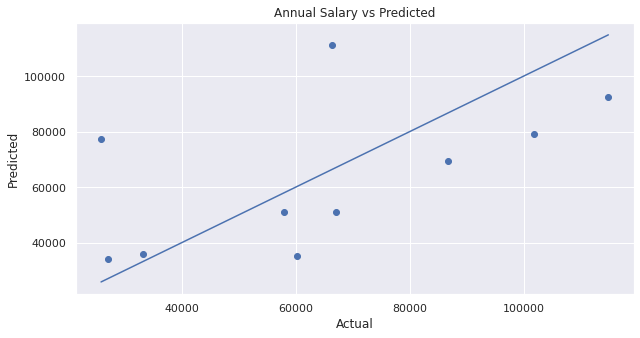

In [26]:
# Plot of predicted salary against actual salary
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict_3)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Annual Salary vs Predicted")
plt.show()

Finally, we can see that the Decision Tree model was more accurate than the Linear Regressor. But in my analysis, I discovered that the Random Forest Regressor is even more accurate and this is the one ANZ should use!